In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from empiricaldist import Pmf, Cdf
from matplotlib.ticker import MaxNLocator
%matplotlib inline  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import scipy.stats as stats
from feature_engine import variable_transformers as vt
from sklearn.preprocessing import StandardScaler

In [19]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [20]:
# transform type

train_data[["MoSold", "MSSubClass"]] = train_data[["MoSold", "MSSubClass"]].astype(str)
# transform type

test_data[["MoSold", "MSSubClass"]] = test_data[["MoSold", "MSSubClass"]].astype(str)

In [21]:
# separate object and numerical columns. Separate area and surface area columns and year columns as wel

cat_cols = [x for x in train_data.columns if train_data[x].dtype==np.object]
num_cols = [x for x in train_data.columns if (train_data[x].dtype!=np.object) and (x not in ['Id', 'YrSold',
                                                                                             'MiscVal', 'SalePrice'])]
area_cols = [x for x in train_data.columns if ("SF" in x)|("Area" in x)|(x=="LotFrontage")]
year_cols = [x for x in num_cols if 'Yr' in x or 'Year' in x]

In [22]:
# split train and test

X_train = train_data.drop(['Id', 'SalePrice'], axis=1)
X_test = test_data.drop('Id', axis=1)
y_train = train_data['SalePrice']


X_train.shape, X_test.shape


((1460, 79), (1459, 79))

In [23]:
# function to calculate elapsed time

def elapsed_years(df, cols):
    # capture difference between year col and
    # year the house was sold
    for col in cols:
        if col=='YrSold':
            continue
        df[col] = df['YrSold'] - df[col]
   
    return df

X_train = elapsed_years(X_train, year_cols)
X_test = elapsed_years(X_test, year_cols)

In [24]:
# lets drop YrSold and MiscVal

X_train.drop(['YrSold', 'MiscVal'], axis=1, inplace=True)
X_test.drop(['YrSold', 'MiscVal'], axis=1, inplace=True)

In [25]:
# lets check missing values
for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        print(col, X_train[col].isnull().mean())

LotFrontage 0.1773972602739726
Alley 0.9376712328767123
MasVnrType 0.005479452054794521
MasVnrArea 0.005479452054794521
BsmtQual 0.025342465753424658
BsmtCond 0.025342465753424658
BsmtExposure 0.026027397260273973
BsmtFinType1 0.025342465753424658
BsmtFinType2 0.026027397260273973
Electrical 0.0006849315068493151
FireplaceQu 0.4726027397260274
GarageType 0.05547945205479452
GarageYrBlt 0.05547945205479452
GarageFinish 0.05547945205479452
GarageQual 0.05547945205479452
GarageCond 0.05547945205479452
PoolQC 0.9952054794520548
Fence 0.8075342465753425
MiscFeature 0.963013698630137


In [26]:
# lets check missing values
for col in X_test.columns:
    if X_test[col].isnull().sum() > 0:
        print(col, X_test[col].isnull().mean())

MSZoning 0.0027416038382453737
LotFrontage 0.15558601782042494
Alley 0.9266620973269363
Utilities 0.0013708019191226869
Exterior1st 0.0006854009595613434
Exterior2nd 0.0006854009595613434
MasVnrType 0.010966415352981495
MasVnrArea 0.01028101439342015
BsmtQual 0.03015764222069911
BsmtCond 0.030843043180260453
BsmtExposure 0.03015764222069911
BsmtFinType1 0.02878684030157642
BsmtFinSF1 0.0006854009595613434
BsmtFinType2 0.02878684030157642
BsmtFinSF2 0.0006854009595613434
BsmtUnfSF 0.0006854009595613434
TotalBsmtSF 0.0006854009595613434
BsmtFullBath 0.0013708019191226869
BsmtHalfBath 0.0013708019191226869
KitchenQual 0.0006854009595613434
Functional 0.0013708019191226869
FireplaceQu 0.5003427004797807
GarageType 0.0520904729266621
GarageYrBlt 0.053461274845784786
GarageFinish 0.053461274845784786
GarageCars 0.0006854009595613434
GarageArea 0.0006854009595613434
GarageQual 0.053461274845784786
GarageCond 0.053461274845784786
PoolQC 0.997943797121316
Fence 0.8012337217272104
MiscFeature 0.

In [27]:
# impute numerical cols with median value

# define an imputation function
def impute_na_median(df, cols):
    for col in cols:
        df[col]= df[col].fillna(df[col].median())
    
    return df

# apply on train set and test set
X_train_imp = impute_na_median(X_train, cols=num_cols)
X_test_imp = impute_na_median(X_test, cols=num_cols)

In [28]:
# impute cat cols with a 'NA' label

# define an imputation function
def impute_na_label(df, cols):
    for col in cols:
        df[col]= df[col].fillna('NA')
    
    return df

# apply on train set and test set
X_train_imp = impute_na_label(X_train_imp, cols=cat_cols)
X_test_imp = impute_na_label(X_test_imp, cols=cat_cols)

In [29]:
# transform the area columns to enhance skew

yjt = vt.YeoJohnsonTransformer(variables = area_cols)
yjt.fit(X_train_imp)
print(yjt.lambda_dict_)
X_train_imp_tr = yjt.transform(X_train_imp)
X_test_imp_tr = yjt.transform(X_test_imp)

{'LotFrontage': 0.4155172353595565, 'LotArea': 0.03081854079393649, 'MasVnrArea': -0.24430146914434417, 'BsmtFinSF1': 0.22872562524018467, 'BsmtFinSF2': -1.5215505484996374, 'BsmtUnfSF': 0.4712723599394073, 'TotalBsmtSF': 0.7396016878493652, '1stFlrSF': -0.07987709830415687, '2ndFlrSF': -0.12741730779016755, 'LowQualFinSF': -10.018636837166552, 'GrLivArea': 0.005539641278705955, 'GarageArea': 0.8112580246118668, 'WoodDeckSF': -0.078596115085857, 'OpenPorchSF': 0.011642789763656977, 'PoolArea': -32.86118772770139}


In [30]:
# Apply rare label encoding on some of the cat cols

rare_encoder = RareLabelCategoricalEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=3, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=cat_cols # apply to all categorical columns
) 

rare_encoder.fit(X_train_imp_tr)
X_train_imp_tr_enc = rare_encoder.transform(X_train_imp_tr)
X_test_imp_tr_enc = rare_encoder.transform(X_test_imp_tr)

In [31]:
# Apply hot one encoding next

ohe_enc = OneHotCategoricalEncoder(
    top_categories=None,
    drop_last=False) # automatically detects all cat vars in data

ohe_enc.fit(X_train_imp_tr_enc)

X_train_imp_tr_enc = ohe_enc.transform(X_train_imp_tr_enc)
X_test_imp_tr_enc = ohe_enc.transform(X_test_imp_tr_enc)

In [32]:
# scaling the features since we will be using LR

scaler = StandardScaler()
scaler.fit(X_train_imp_tr_enc)

# transform 
X_train_imp_tr_enc_sc = scaler.transform(X_train_imp_tr_enc)
X_test_imp_tr_enc_sc = scaler.transform(X_test_imp_tr_enc)

In [33]:
lightgbm_regr = LGBMRegressor(ambda_l1=1.0, feature_fraction=0.30, num_leaves=31, bagging_fraction=0.50, 
                                 bagging_freq=5, max_depth=9)

lightgbm_regr.fit(X_train_imp_tr_enc_sc, y_train)

y_pred_train = lightgbm_regr.predict(X_train_imp_tr_enc_sc)
y_pred_test = lightgbm_regr.predict(X_test_imp_tr_enc_sc)

In [34]:
print('train mse: {}'.format(mean_squared_error(y_train, y_pred_train)))
print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('train r2: {}'.format(r2_score(y_train, y_pred_train)))
print('train rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred_train)))))


train mse: 375701907.89621824
train rmse: 19383.031442378106
train r2: 0.9404289674829158
train rmsle: 0.08766882407159453


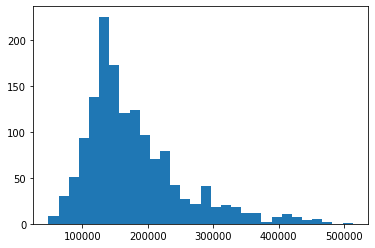

In [35]:
plt.hist(y_pred_test,bins=30);

In [36]:
submission_df = pd.DataFrame(y_pred_test)

In [38]:
submission_df.columns = ['SalePrice']

submission_df.head()

,SalePrice
0,127138.393378
1,162616.017580
2,188509.985406
3,190823.816258
4,182121.578676


In [41]:
test_data_df = pd.read_csv("test.csv")

submission_df['Id'] = test_data_df['Id']

submission_df.head()

,SalePrice,Id
0,127138.393378,1461
1,162616.017580,1462
2,188509.985406,1463
3,190823.816258,1464
4,182121.578676,1465


In [45]:
submission_df.to_csv("kaggle_submission.csv", index=False)

In [46]:
submission_check_df = pd.read_csv("kaggle_submission.csv")

In [47]:
submission_check_df.head()

,SalePrice,Id
0,127138.393378,1461
1,162616.017580,1462
2,188509.985406,1463
3,190823.816258,1464
4,182121.578676,1465
